## Task
https://docs.google.com/document/d/1j_489jZ0xQEItZue1ofjft3nDUYjMGlRLh2hoo2VjFg/edit

In [85]:
import os
from random import random, randrange, seed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, MaxPooling2D, Dropout, Flatten, \
                          BatchNormalization, Conv2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [86]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [87]:
link_test = 'https://drive.google.com/file/d/10kc9oBGbmtSZS8oQ6zilF_yzhOPzgtKz/view?usp=sharing'
link_train = 'https://drive.google.com/file/d/1wrPV8lm4FujT097ygNT4rARwYAsD7prm/view?usp=sharing'

# to get the id part of the file
id_test = link_test.split("/")[-2]
id_train = link_train.split("/")[-2]

downloaded = drive.CreateFile({'id':id_test})
downloaded.GetContentFile('test.zip')

downloaded = drive.CreateFile({'id':id_train})
downloaded.GetContentFile('train.zip')

In [88]:
%%time

!unzip test.zip -d test/
!unzip train.zip -d train/

Archive:  test.zip
replace test/test1/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  train.zip
replace train/train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
CPU times: user 72.2 ms, sys: 4.07 ms, total: 76.3 ms
Wall time: 8.68 s


## Loading data in DataFrame

In [89]:
image_dir = "train/train"

filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()

,filename,label
0,dog.11114.jpg,dog
1,cat.9429.jpg,cat
2,cat.687.jpg,cat
3,cat.5653.jpg,cat
4,dog.6279.jpg,dog


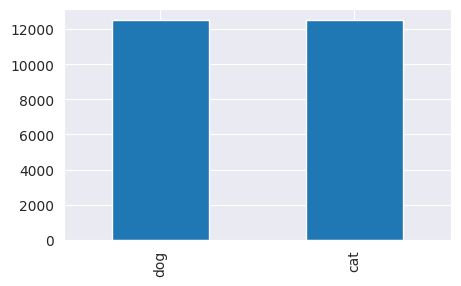

In [119]:
plt.figure(figsize=(5, 3))
data['label'].value_counts().plot.bar()
plt.show()

## EDA

In [91]:
seed(13)

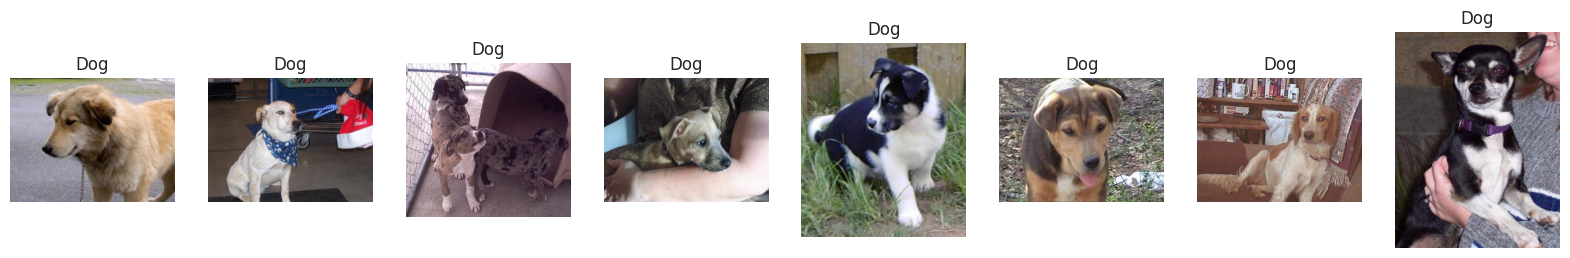

In [92]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.4)

for i in range(8):
    plt.subplot(1, 8, i+1)
    filename = 'train/train/' + 'dog.' + str(randrange(1, 2500)) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog', fontsize=12)
    plt.axis('off')

plt.show()

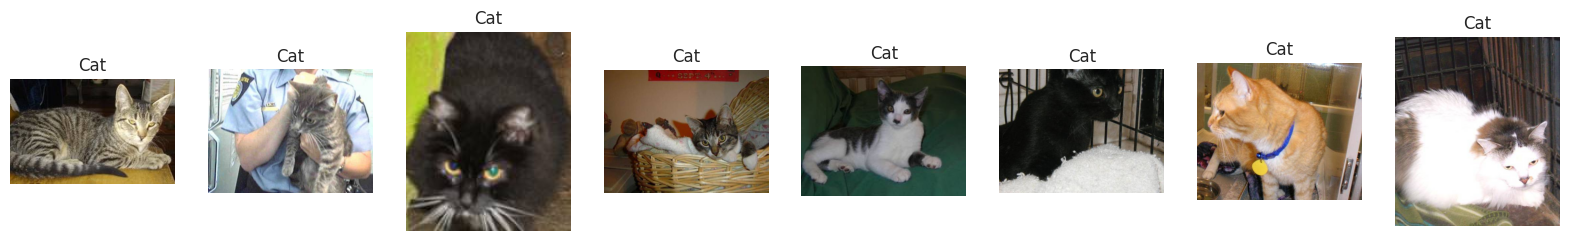

In [93]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.4)
lenght = len(data)

for i in range(8):

    plt.subplot(1, 8, i+1)
    filename = 'train/train/' + 'cat.' + str(randrange(1, 2500)) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Cat', fontsize=12)
    plt.axis('off')

plt.show()

In [94]:
labels = data['label']

X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels, random_state=13)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state=13)

print('The shape of train data', X_train.shape)
print('The shape of test data', X_test.shape)
print('The shape of validation data', X_val.shape)

The shape of train data (20000, 2)
The shape of test data (2500, 2)
The shape of validation data (2500, 2)


In [95]:
image_size = 128
image_channel = 3
bat_size = 32

## Image data generator

In [96]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=15,
                                    horizontal_flip=True,
                                    zoom_range=0.2,
                                    shear_range=0.1,
                                    fill_mode='reflect',
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

In [97]:
# Applying image data gernerator to train and test data
train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory='train/train/',
                                                    x_col='filename',
                                                    y_col='label',
                                                    batch_size=bat_size,
                                                    target_size=(image_size, image_size)
                                                   )
val_generator = test_datagen.flow_from_dataframe(X_val,
                                                 directory ='train/train/',
                                                 x_col='filename',
                                                 y_col='label',
                                                 batch_size=bat_size,
                                                 target_size=(image_size, image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test,
                                                  directory='train/train/',
                                                  x_col='filename',
                                                  y_col='label',
                                                  batch_size=bat_size,
                                                  target_size=(image_size, image_size),
                                                  shuffle=False
                                                 )

Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


## Modeling

In [98]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3, 3), activation='leaky_relu', input_shape=(image_size, image_size, image_channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Bloack 1
model.add(Conv2D(64,(3, 3), activation='leaky_relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block 2
model.add(Conv2D(128,(3, 3), activation='leaky_relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block 3
model.add(Conv2D(256, (3, 3), activation='leaky_relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Fully Connected layers
model.add(Flatten())
model.add(Dense(512, activation='leaky_relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_25 (Ba  (None, 126, 126, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_25 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_26 (Ba  (None, 61, 61, 64)       

**ReduceLROnPlateau**: Reduce learning rate when a metric has stopped improving

**EarlyStopping**: Stop training when a monitored metric has stopped improving

In [99]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr=0.00001,
                                            verbose=1)

early_stoping = EarlyStopping(monitor='val_loss',
                              patience=3,
                              restore_best_weights=True,
                              verbose=1)

In [100]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [101]:
%%time

cat_dog = model.fit(train_generator,
                    validation_data=val_generator,
                    callbacks=[early_stoping, learning_rate_reduction],
                    epochs=30
                   )

Epoch 1/30
625/625 [==============================] - 130s 193ms/step - loss: 0.6846 - accuracy: 0.6542 - val_loss: 0.5192 - val_accuracy: 0.7384 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - 114s 182ms/step - loss: 0.5469 - accuracy: 0.7304 - val_loss: 0.6026 - val_accuracy: 0.7032 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 114s 183ms/step - loss: 0.4867 - accuracy: 0.7650 - val_loss: 0.4456 - val_accuracy: 0.8108 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - 115s 184ms/step - loss: 0.4394 - accuracy: 0.7939 - val_loss: 0.4493 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 117s 187ms/step - loss: 0.4129 - accuracy: 0.8082 - val_loss: 0.5032 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - 115s 184ms/step - loss: 0.3879 - accuracy: 0.8239 - val_loss: 0.4332 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 7/30
625/625 [==========================

## Plot the results

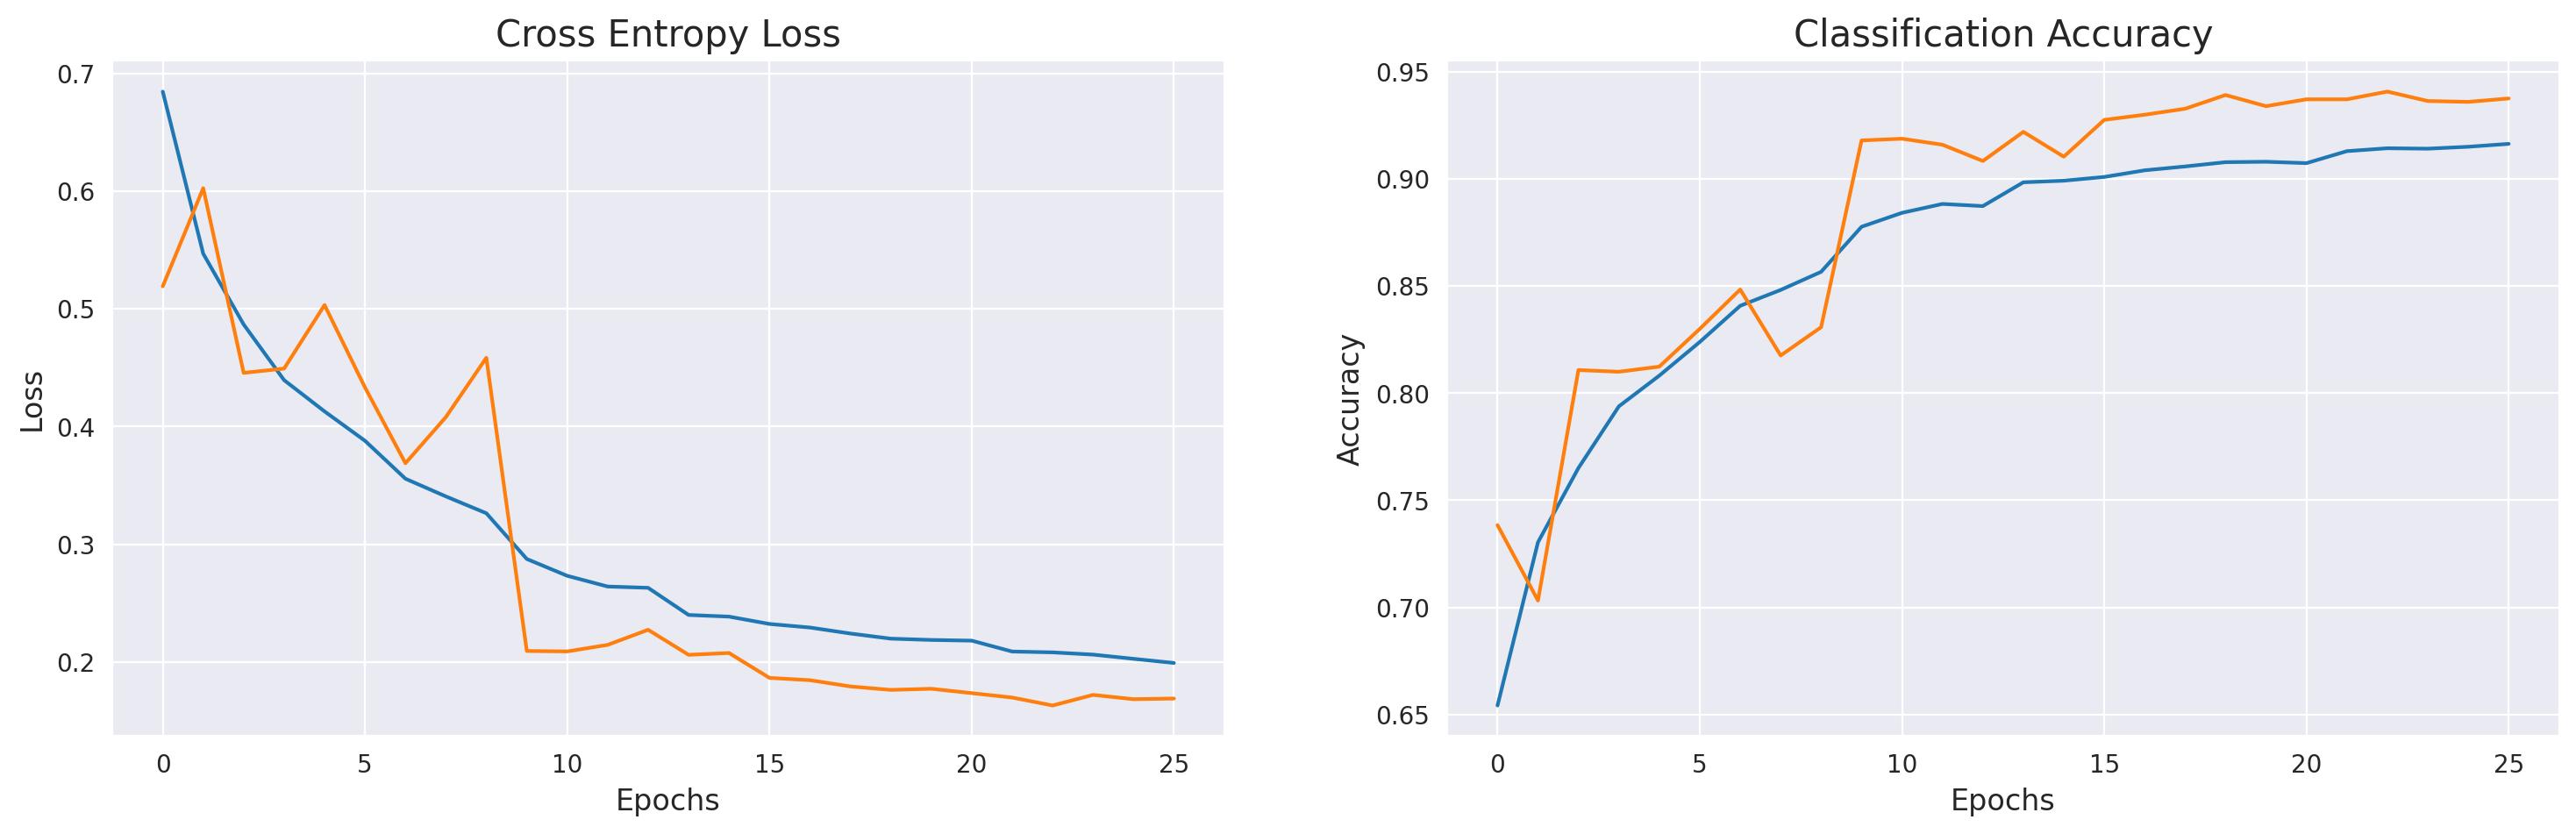

In [111]:
error = pd.DataFrame(cat_dog.history)

plt.figure(figsize=(18, 5), dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

## Evaluation

In [103]:
# Evaluvate for train generator
loss, acc = model.evaluate(train_generator, batch_size=bat_size, verbose=1)

print('The accuracy of the model for training data is:', acc * 100)
print('The Loss of the model for training data is:', loss)

# Evaluvate for validation generator
loss, acc = model.evaluate(val_generator, batch_size=bat_size, verbose=1)

print('The accuracy of the model for validation data is:', acc * 100)
print('The Loss of the model for validation data is:', loss)

625/625 [==============================] - 103s 165ms/step - loss: 0.1353 - accuracy: 0.9467
The accuracy of the model for training data is: 94.67499852180481
The Loss of the model for training data is: 0.13534314930438995
79/79 [==============================] - 4s 46ms/step - loss: 0.1629 - accuracy: 0.9408
The accuracy of the model for validation data is: 94.08000111579895
The Loss of the model for validation data is: 0.16294652223587036


## Saving model

In [104]:
model.save('cat_vs_dog_model.keras')

## Prediction

In [105]:
result = model.predict(test_generator, batch_size=bat_size, verbose=1)

y_pred = np.argmax(result, axis=1)

y_true = test_generator.labels

# Evaluvate
loss, acc = model.evaluate(test_generator, batch_size=bat_size)

print('\nThe accuracy of the model for testing data is:', acc * 100)
print('The Loss of the model for testing data is:', loss)

79/79 [==============================] - 4s 47ms/step - loss: 0.1432 - accuracy: 0.9460

The accuracy of the model for testing data is: 94.59999799728394
The Loss of the model for testing data is: 0.14317147433757782


## Report

In [106]:
labels = ['Cat', 'Dog']
print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

         Cat       0.95      0.95      0.95      1250
         Dog       0.95      0.95      0.95      1250

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500



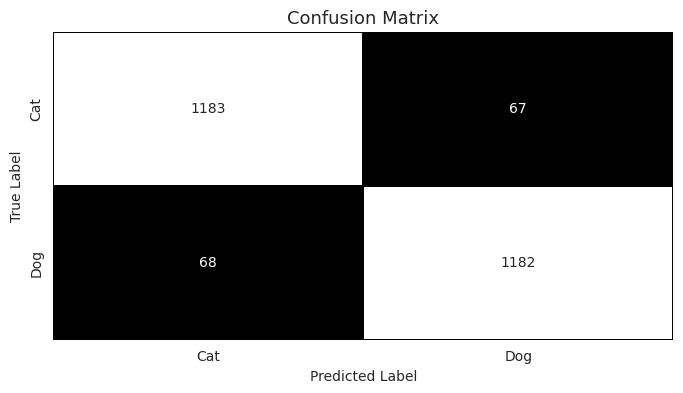

In [113]:
confusion_mtx = confusion_matrix(y_true, y_pred)

f, ax = plt.subplots(figsize=(8,4), dpi=100)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r",
            linecolor="black", fmt='.0f', ax=ax, cbar=False, xticklabels=labels,
            yticklabels=labels)

plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)
plt.title("Confusion Matrix", fontsize=13)

plt.show()

In [108]:
size =(128,128)

# loading into dataframe
test_dir = "test/test1/"
filenames = os.listdir(test_dir)
test_data = pd.DataFrame({"filename": filenames})
test_data['label'] = 'unknown'

# Create data genenerator for test data
test1_idg =  test_datagen.flow_from_dataframe(test_data,
                                     "test/test1/",
                                     x_col="filename",
                                     y_col='label',
                                     batch_size=bat_size,
                                     target_size=size,
                                     shuffle=False)

# Test Prediction
test1_predict = model.predict(test1_idg, verbose=1)

test1_predict_argmax = np.argmax(test1_predict, axis=1)

y_test_pred = test1_predict_argmax

test_data['label'] = y_test_pred

# mapping
label_mapping = {0: 'cat', 1: 'dog'}
test_data['label'] = test_data['label'].map(label_mapping)
test_data.head()

Found 12500 validated image filenames belonging to 1 classes.
391/391 [==============================] - 19s 50ms/step


,filename,label
0,11655.jpg,dog
1,2893.jpg,cat
2,10772.jpg,cat
3,2924.jpg,dog
4,4991.jpg,cat


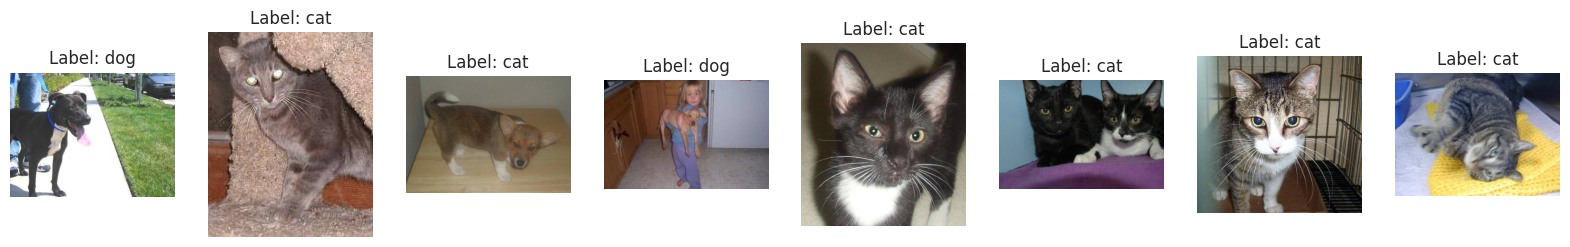

In [109]:
fig, axes = plt.subplots(1, 8, figsize=(20, 4))

for idx in range(8):
    image_path = os.path.join(test_dir, test_data.iloc[idx]['filename'])
    image = Image.open(image_path)
    axes[idx].imshow(image)
    axes[idx].set_title("Label: " + test_data.iloc[idx]['label'])
    axes[idx].axis('off')

plt.show()